In [140]:
import numpy as np
import pandas as pd

In [141]:
# Import dataset and analyze
dataset = pd.read_csv("movie.csv")

Analyze the dataset 

In [142]:
dataset.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


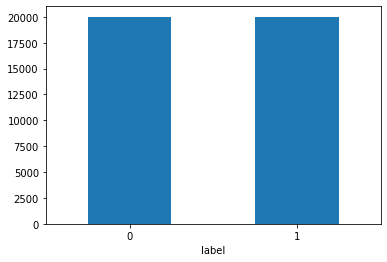

In [143]:
# Data distribution
Data_distribution = dataset.groupby('label').count()
Plot = Data_distribution.plot.bar(rot=0,legend=False)

In [ ]:
# Create the datset
X=dataset['text']
y=dataset['label']
X_negative=[X[i] for i in range(len(X)) if y[i]==0]
X_positive=[X[i] for i in range(len(X)) if y[i]==1]

In [ ]:
# Split the data into training and testing 
X_train_0=X_negative[0:15000]
X_train_1=X_positive[0:15000]
X_test_0=X_negative[15000:]
X_test_1=X_positive[15000:]

In [ ]:
# Create the Synthetic data
# import openai libraries
# Do not run the  below 6 cells. Data created beforehand
import os
import openai
openai.api_key = "My API key"

In [ ]:
# create a csv file with data to fine-tune GPT-3
# 100 positive and 100 negative samples were used for fine-tuning
# Limited by the credits
import csv
val=[]
header=['prompt','completion']
with open('gpt3_train.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(0,200):
        if(i<100):
            temp=['positive sentiment\n\n###\n\n'," "+X_train_1[i]]
        else:
            temp=['negative sentiment\n\n###\n\n'," "+X_train_0[i]]
        writer.writerow(temp)

In [ ]:
# will create a jsonl file from the csv file to be used for fine-tunning
!yes | openai tools fine_tunes.prepare_data -f 'gpt3_train.csv'
# will prepare the file on the openai-server
with open("gpt3_train_prepared.jsonl") as f:
      info = openai.File.create(file=f, purpose='fine-tune')

In [ ]:
# will fin-tune the curie model with my training file for 1 epoch
info = openai.FineTune.create(training_file="file-3WBfh63bfdPaJb94yP3UrSgB", model='curie',n_epochs=1)

In [ ]:
# function to prompt GPT-3 and create new data
def create_synthetic_data(file_name,sentiment,no_queries):
    with open(file_name, 'a') as f:
        for i in range(0,no_queries):
            info = openai.Completion.create(engine="curie:ft-personal-2022-11-28-23-27-31",
                                            prompt=sentiment+" sentiment\n\n###\n\n",
                                            temperature=0.7,
                                            max_tokens=250,
                                            top_p=1.0,
                                            frequency_penalty=0.0,
                                            presence_penalty=0.0)
            f.write(response['choices'][0]['text'])
            f.write('\n')
    

In [ ]:
# create the positive and negative synthetic data
create_synthetic_data("gpt_negative_fine_tune.txt","negative",3000)
create_synthetic_data("gpt_positive_fine_tune.txt","positive",3000)

In [ ]:
# Creating synthetic data using prompts
# Not used in final results !
with open('gpt_negative_prompt.txt', 'a') as f:
    for i in range(4000,len(X_train_1)-3,3):
        print(i)
        gpt_prompt="sentiment: negative \ntext:"+X_train_0[i]+"\nsentiment: negative\ntext:"+X_train_0[i+1]+"\nsentiment: negative \ntext:"+X_train_0[i+2]+"\nsentiment: negative\ntext:"
        response = openai.Completion.create(
  engine="text-davinci-002",
  prompt=gpt_prompt,
  temperature=0.7,
  max_tokens=1000,
  top_p=1.0,
  frequency_penalty=0.0,
  presence_penalty=0.0
)
        f.write(response['choices'][0]['text'])
        f.write('\n')
        
with open('gpt_postive_prompt.txt', 'a') as f:
    for i in range(4000,len(X_train_1)-3,3):
        print(i)
        gpt_prompt="sentiment: positive \ntext:"+X_train_0[i]+"\nsentiment: positive\ntext:"+X_train_0[i+1]+"\nsentiment: positive \ntext:"+X_train_0[i+2]+"\nsentiment: positive\ntext:"
        response = openai.Completion.create(
  engine="text-davinci-002",
  prompt=gpt_prompt,
  temperature=0.7,
  max_tokens=1000,
  top_p=1.0,
  frequency_penalty=0.0,
  presence_penalty=0.0
)
        f.write(response['choices'][0]['text'])
        f.write('\n')


In [196]:
# postive examples from dataset
X_positive[4:6]

["I can't believe people are looking for a plot in this film. This is Laural and Hardy. Lighten up already. These two were a riot. Their comic genius is as funny today as it was 70 years ago. Not a filthy word out of either mouth and they were able to keep audiences in stitches. Their comedy wasn't sophisticated by any stretch. If a whoopee cushion can't make you grin, there's no reason to watch any of the stuff these guys did. It was a simpler time, and people laughed at stuff that was funny without a plot. I guess it takes a simple mind to enjoy this stuff, so I qualify. Two man comedy teams don't compute, We're just too sophisticated... Aren't we fortunate?",
 'I have always been a huge fan of "Homicide: Life On The Street" so when I heard there was a reunion movie coming up, I couldn\'t wait.<br /><br />Let me just say, I was not disappointed at all. It was one of the most powerful 2 hours of television I\'ve ever seen. It was great to see everyone back again, but the biggest pleas

In [198]:
# negative examples from dataset
X_negative[2:4]

['Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you\'ve got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and who failed grade school composition do? "I\'ll show those old meanies, I\'ll put out my own movie and prove that you don\'t have to know nuttin about your topic to still make money!" Yeah, we already know that. The one thing watching this film did for me was to give me a little insight into underclass thinking. The next time I see a slut in a bar who looks like Diane Lane, I\'m running the other way. It\'s child abuse to let parents that worthless raise kids. It\'s audience abuse to simply stick Woodstock and the moonlanding into a flick as if that ipso facto means the film portrays 1969.',
 'Eve

In [200]:
# retrive all synthetic data with more than 50 characters
# sometimes GPT-3 will return very short responses which we discard
x_neg_fine_tune= [ val for val in open("gpt_negative_fine_tune.txt").readlines() if len(val)>50]
x_pos_fine_tune= [ val for val in open("gpt_positive_fine_tune.txt").readlines() if len(val)>50]

In [202]:
# postive examples from synthetic-data
x_pos_fine_tune[0:2]

[" I saw this movie yesterday (it's a new release) and I have to say, I loved it. I absolutely loved it. It was a very enjoyable film experience. I don't even know if I can think of anything negative to say about it. <br /><br />Now I'm not a big fan of the romantic comedies, and in fact I could care less about Hollywood movies in general, but I watched this movie as I was leaving work, so I wanted to see if I was going to be entertained. And, man, was I! I laughed, I cried and I got chills. I don't know if this is a good movie or not, I haven't seen it since the theatre, but I know that it was a fun movie. And I'm pretty sure I know why. <br /><br />Pete. <br /><br />Pete is the main character, and I think he's a great character. Very multi-dimensional. He's a very good actor, I've never seen him in anything before, so I have no idea how he's going to do in the future. I don't think he's going to go too far, because he's definitely\n",
 " A high-octane, no-holds-barred action-adventur

In [222]:
# negative examples from synthetic-data
x_neg_fine_tune[1:3]

[" This movie has not aged well at all. The script is rather silly, the pacing is flat and the acting is atrocious. In fact, I'm surprised that this movie has any cult following at all. Essentially, the plot is that some people get transported to hell when they die and they have to fight their way back.<br /><br />The characters are not very well developed and most of them are simply there to provide a plot device. The movie is actually not all that bad in that regard, as it is not any worse than most horror movies of the time. However, the movie is not for everyone. The acting is atrocious and the dialogue is not very good at all. The pacing is bad and the camera work is also not very good. The movie also has a lot of annoying CG effects which detract from the film.<br /><br />I would recommend this movie for hardcore horror fans only. Not for anyone else.\n",
 " I have to say that I'm really surprised that so many people have rated this movie so highly. First of all, the movie was ba

In [308]:
# create the data to train the model (very low data,low data,high data, very high data)
X_train=X_train_1[0:5000]+x_pos_fine_tune[0:2000]+x_neg_fine_tune[0:2000]+X_train_0[0:5000]
X_test=X_test_1[0:2000]+X_train_0[0:2000]
y_train=[1*(i<7000) for i in range(14000)]
y_test=[1*(i<2000) for i in range(4000)]

In [309]:
# Import Libraries
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import re
lemmatizer=WordNetLemmatizer()
s = PorterStemmer()

In [310]:
# Cleaning the data
def data_cleaning(text_corpus): 
    cleaned_corpus=[]
    for text in text_corpus: 
        text = text.translate(string.punctuation)
        text = text.replace('\n', ' ')
        text = text.replace('<br />', '')
        re.sub("\s\s+" , " ", text)
        tokens=word_tokenize(text.lower())
        stem_tokens=[s.stem(word) for word in tokens]
        cleaned_corpus.append(' '.join(stem_tokens))
    return cleaned_corpus

In [311]:
# train
cleaned_data_train=data_cleaning(X_train)
tfidf=TfidfVectorizer(max_features=100000, ngram_range=(1, 3))
tfidf.fit(cleaned_data_train)
X_train_final=tfidf.transform(cleaned_data_train) 

# test
cleaned_data_test=data_cleaning(X_test)
X_test_final=tfidf.transform(cleaned_data_test)

In [312]:
# Create a Naive Bayes model and fit training data
nb=MultinomialNB()
nb.fit(X_train_final, y_train)

# Evaluate model
print("Train Score",nb.score(X_train_final, y_train))
print("Test Score",nb.score(X_test_final, y_test))
y_pred = nb.predict(X_test_final)

Train Score 0.9205714285714286
Test Score 0.9065


In [313]:
# Create a Linear Regression model and fit training data
clf = LogisticRegression(C=1.0)
clf.fit(X_train_final, y_train)
pred = clf.predict(X_test_final)

# Evaluate model
print("Train Score",clf.score(X_train_final, y_train))
print("Test Score",clf.score(X_test_final, y_test))

Train Score 0.931
Test Score 0.9145


In [314]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def show_results(y,y_test,title):
    y_pred = [1*(x>=0.5) for x in y]
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    ax.set_title(title)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap="Blues" ,ax = ax)
    plt.show()
    print(classification_report(y_test, y_pred))

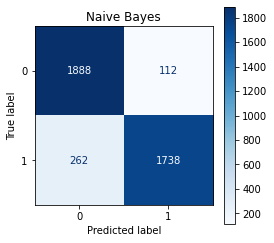

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2000
           1       0.94      0.87      0.90      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



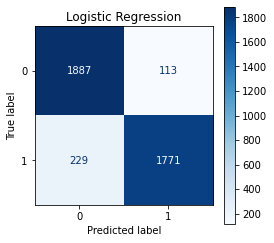

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2000
           1       0.94      0.89      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.92      0.91      0.91      4000
weighted avg       0.92      0.91      0.91      4000



In [315]:
show_results(y_pred,y_test,"Naive Bayes")
show_results(pred,y_test,"Logistic Regression")

In [320]:
def run_test_original(size,synthetic):
    if synthetic==False:
        X_train=X_train_1[0:size]+X_train_0[0:size]
        y_train=[1*(i<size) for i in range(2*size)]
    else:
        X_train=X_train_1[0:size]+x_pos_fine_tune[0:2000]+x_neg_fine_tune[0:2000]+X_train_0[0:size]
        y_train=[1*(i<(size+2000)) for i in range(2*(size+2000))]

    X_test=X_test_1[0:2000]+X_train_0[0:2000]
    y_test=[1*(i<2000) for i in range(4000)]
        
    cleaned_data_train=data_cleaning(X_train)
    tfidf=TfidfVectorizer(max_features=100000, ngram_range=(1, 3))
    tfidf.fit(cleaned_data_train)
    X_train_final=tfidf.transform(cleaned_data_train) 
    cleaned_data_test=data_cleaning(X_test)
    X_test_final=tfidf.transform(cleaned_data_test)
    clf = LogisticRegression(C=1.0)
    clf.fit(X_train_final, y_train)
    pred = clf.predict(X_test_final)
    return(clf.score(X_test_final, y_test))
    

In [328]:
# Lets create a plot of increase in accuracy vs data size
data_size=[100,250,500,750,1000,1250]
acc_diff=[]
for d in data_size:
    acc_1=run_test_original(d,False)
    acc_2=run_test_original(d,True)
    acc_diff.append(acc_2-acc_1)
    

In [329]:
final_acc=[x*(x>0)*100 for x in acc_diff ]

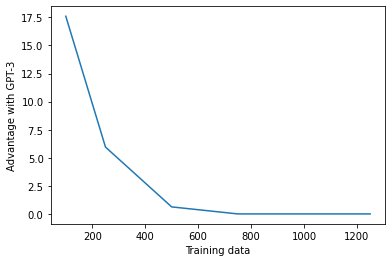

In [332]:
plt.plot(data_size,final_acc)
plt.ylabel('Advantage with GPT-3')
plt.xlabel('Training data')
plt.show()